## pipeline

In [8]:
import numpy as np
import os
import pickle
import copy
import edt
import matplotlib.pyplot as plt
import time
import cv2
import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score
from skimage.metrics import adapted_rand_error
import h5py

import torch
from torch import from_numpy as from_numpy
from torchsummary import summary

from func.run_pipeline_super_vox import segment_super_vox_2_channel, semantic_segment_crop_and_cat_2_channel_output, img_3d_erosion_or_expansion, \
generate_super_vox_by_watershed, get_outlayer_of_a_3d_shape, get_crop_by_pixel_val, Cluster_Super_Vox, assign_boudary_voxels_to_cells_with_watershed, \
delete_too_small_cluster, reassign
from func.run_pipeline import segment, assign_boudary_voxels_to_cells, dbscan_of_seg, semantic_segment_crop_and_cat
from func.cal_accuracy import IOU_and_Dice_Accuracy, VOI
from func.network import VoxResNet, CellSegNet_basic_lite
from func.unet_3d_basic import UNet3D_basic
from func.ultis import save_obj, load_obj

### init model

In [9]:
#model=UNet3D_basic(in_channels = 1, out_channels = 2)
#load_path=''
#model=VoxResNet(input_channel=1, n_classes=2, output_func = "softmax")
#load_path=''
model=CellSegNet_basic_lite(input_channel=1, n_classes=2, output_func = "softmax")
load_path='output/model_LRP_retrained.pkl'
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

#summary(model, (1, 64, 64, 64))

CellSegNet_basic_lite(
  (conv1): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bnorm1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule1): ResModule(
    (batchnorm_module): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_module): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (conv4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule2): ResModule(
    (batchnorm_module): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_module): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (conv5): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule3): R

### dataset info

In [10]:
data_dict = load_obj("dataset_info/LRP_dataset_info")
data_dict_test = data_dict["test"]

### seg one img

parameter setting

In [11]:
# we do not input the whole raw image to the model one time but input raw image crops
crop_cube_size=128
stride=64

# hyperparameter for TASCAN, min touching area of two super pixels if they belong to the same cell
min_touching_area=30

choose a test image and load it

In [12]:
print("there are test imgs: "+str(data_dict_test.keys()))
case = 'Movie2_T00010_crop_gt.h5'
print("for test case "+str(case)+" : "+str(data_dict_test[case]))

there are test imgs: dict_keys(['Movie2_T00010_crop_gt.h5', 'Movie1_t00006_crop_gt.h5', 'Movie1_t00045_crop_gt.h5', 'Movie2_T00020_crop_gt.h5'])
for test case Movie2_T00010_crop_gt.h5 : data/CellSeg_dataset/LateralRootPrimordia_processed_wide_boundary/test/Movie2_T00010_crop_gt.h5


In [13]:
hf = h5py.File(data_dict_test[case], 'r')
print(hf.keys())
raw_img = np.array(hf["raw"], dtype=np.float)
hand_seg = np.array(hf["ins"], dtype=np.float)
boundary_gt = np.array(hf["boundary"], dtype=np.float)
background_gt = np.array(hf["background"], dtype=np.float)
foreground_gt = np.array(hf["foreground"], dtype=np.float)

print("raw_img shape: "+str(raw_img.shape))
print("hand_seg shape: "+str(hand_seg.shape))
raw_img_shape = raw_img.shape
hand_seg_shape = hand_seg.shape

<KeysViewHDF5 ['background', 'boundary', 'edge_background', 'edge_boundary', 'edge_foreground', 'foreground', 'ins', 'raw']>


/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_7955/1358275588.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  raw_img = np.array(hf["raw"], dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_7955/1358275588.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hand_seg = np.array(hf["ins"], dtype=np.

raw_img shape: (201, 225, 795)
hand_seg shape: (201, 225, 795)


feed raw image crops to the model

In [14]:
start = time.time()

transposes = [[0,1,2],[2,0,1],[0,2,1]]#,[1,0,2]]
reverse_transposes = [[0,1,2],[1,2,0],[0,2,1]]#,[1,0,2]]

# feed the raw img to the model
print('Feed raw img to model. Use different transposes')
raw_img_size=raw_img.shape
seg_boundary_comp = np.zeros(raw_img_size)
seg_img_boundary_comp = np.zeros(raw_img_size)
for idx, transpose in enumerate(transposes):
    print(str(idx+1)+": Transpose the image to be: "+str(transpose))
    with torch.no_grad():
        seg_img=\
        semantic_segment_crop_and_cat_2_channel_output(raw_img.transpose(transpose), model, device,
                                                       crop_cube_size=crop_cube_size, stride=stride)
    seg_img_boundary=seg_img['boundary']
    seg_img_foreground=seg_img['foreground']
    torch.cuda.empty_cache()
    
    # argmax
    print('argmax', end='\r')
    # probability map to 0 1 segment
    seg_foreground=np.array(seg_img_foreground-seg_img_boundary>0, dtype=np.int)
    seg_boundary=1 - seg_foreground
        
    seg_foreground=seg_foreground.transpose(reverse_transposes[idx])
    seg_boundary=seg_boundary.transpose(reverse_transposes[idx])
    seg_img_foreground=seg_img_foreground.transpose(reverse_transposes[idx])
    seg_img_boundary=seg_img_boundary.transpose(reverse_transposes[idx])
    
    seg_boundary_comp+=seg_boundary
    seg_img_boundary_comp+=seg_img_boundary

print("Get model semantic seg by combination")
seg_boundary_comp = np.array(seg_boundary_comp>0, dtype=np.int)
seg_foreground_comp = 1 - seg_boundary_comp

end = time.time()

print("Time elapsed: ", end - start)

Feed raw img to model. Use different transposes
1: Transpose the image to be: [0, 1, 2]
s of segment_3d_img: 99%

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_7955/4072038333.py:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seg_foreground=np.array(seg_img_foreground-seg_img_boundary>0, dtype=np.int)


2: Transpose the image to be: [2, 0, 1]
s of segment_3d_img: 99%3: Transpose the image to be: [0, 2, 1]
s of segment_3d_img: 99%Get model semantic seg by combination
Time elapsed:  3678.322737932205


/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_7955/4072038333.py:36: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seg_boundary_comp = np.array(seg_boundary_comp>0, dtype=np.int)


5

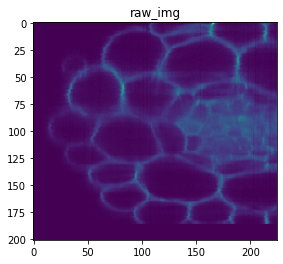

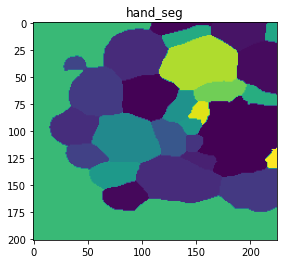

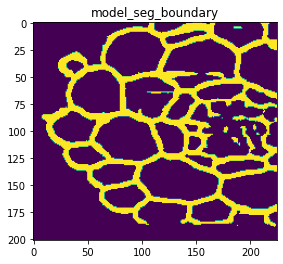

In [15]:
# show current result

N=200

plt.figure()
plt.title("raw_img")
plt.imshow(raw_img[:,:,N])
plt.figure()
plt.title("hand_seg")
plt.imshow(reassign(hand_seg[:,:,N]))
plt.figure()
plt.title("model_seg_boundary")
plt.imshow(seg_boundary_comp[:,:,N])

TASCAN

generate super vox by watershed

In [16]:
# Generate super vox by watershed
how_close_are_the_super_vox_to_boundary=2
min_touching_percentage=0.51

seg_foreground_erosion=1-img_3d_erosion_or_expansion(1-seg_foreground_comp, kernel_size=how_close_are_the_super_vox_to_boundary+1, device=device)
seg_foreground_super_voxel_by_ws = generate_super_vox_by_watershed(seg_foreground_erosion)
# from skimage.measure import label
# from skimage.segmentation import join_segmentations, watershed
# from skimage.feature import peak_local_max
# seg_foreground_edt=edt.edt(np.array(seg_foreground_erosion, dtype=np.uint32, order='F'),
#                            black_border=True, order='F',parallel=1)
# min_distance_between_cells = 5
# coords = peak_local_max(seg_foreground_edt, min_distance=min_distance_between_cells,
#                         labels=np.array(seg_foreground_erosion>0))
# mask = np.zeros(seg_foreground_edt.shape, dtype=bool)
# mask[tuple(coords.T)] = True
# markers = label(mask==True)
# seg_foreground_super_voxel_by_ws = watershed(-seg_foreground_edt, markers=markers, mask=np.array(seg_foreground_comp>0), connectivity=min_touching_area)

In [17]:
print("There are "+str(len(np.unique(seg_foreground_super_voxel_by_ws)))+" super voxels")

There are 11708 super voxels


super voxel clustearing

In [18]:
#Super voxel clustering
cluster_super_vox=Cluster_Super_Vox(min_touching_area=min_touching_area, min_touching_percentage=min_touching_percentage)
cluster_super_vox.fit(copy.deepcopy(seg_foreground_super_voxel_by_ws))
seg_foreground_single_cell_with_boundary = cluster_super_vox.output_3d_img

valid_neighbor_vals: [ 594  644  645  650  732  733  734  736  742  900 1010 1228 1230 1340
 1341 2245 2287 2333 4046 4195 4272 4309 4310 4451 4566 5705 5929 6408
valid_neighbor_vals: [ 593  595  596  599  637  638  639  642  649  651  653  655  656  735
  737  738  739  740  741  747  749  750  754 1229 1336 1337 1339 2139
 2140 2203 2246 3590 3879 4138 4271 4450 4516 4517 4565 4652 5323 5638
 5639 5642 5676 5679 5680 5706 5731 5791 5835 5879 5880 5887 5925 6079
 6088 6140 6141 6272 6273 6275 6369 6448 6449 6450 6491 6493 6564 6672
valid_neighbor_vals: [  392   573   574   575   576   579   580   581   583   584   592   640 55602
   641   657   658   743   745   746   748   751   755   757   758  1338
  2089  2138  3365  3588  3874  3875  3876  3878  4134  4135  4137  4229
  4308  4388  4389  4390  4449  4483  4564  4607  4608  5637  5640  5641
  5675  5677  5678  5757  5758  5792  5833  5834  5836  5881  5882  5883
  5884  5885  5886  5924  5979  5980  6072  6077  6078  6080  6081  6

delete too small cells

In [19]:
# Delete too small cells
min_cell_size_threshold=10
seg_foreground_single_cell_with_boundary = delete_too_small_cluster(seg_foreground_single_cell_with_boundary, threshold=min_cell_size_threshold)

assign boudary voxels to their nearest cells

In [20]:
# Assign boudary voxels to their nearest cells
seg_final=assign_boudary_voxels_to_cells_with_watershed(seg_foreground_single_cell_with_boundary, seg_boundary_comp, compactness=1)

see the final result

6

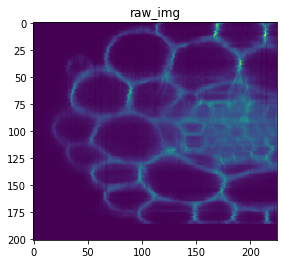

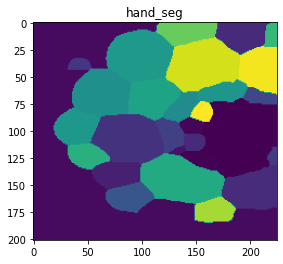

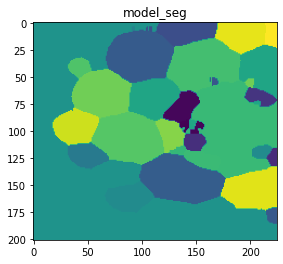

In [21]:
N=250
#print("There are "+str(len(np.unique(seg_foreground_single_cell_with_boundary)))+" cells")
plt.figure()
plt.title("raw_img")
plt.imshow(raw_img[:,:,N])
plt.figure()
plt.title("hand_seg")
plt.imshow(reassign(hand_seg[:,:,N]))
plt.figure()
plt.title("model_seg")
plt.imshow(reassign(seg_final[:,:,N]))

In [2]:
def colorful_seg(seg):
    unique_vals, val_counts = np.unique(seg, return_counts=True)
    
    background_val = unique_vals[np.argsort(val_counts)[::-1][0]]
    
    seg_RGB = []
    for i in range(seg.shape[0]):
        mask_gray = cv2.normalize(src=seg[i,:,:], dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        seg_slice_RGB = cv2.cvtColor(mask_gray, cv2.COLOR_GRAY2RGB)
        seg_RGB.append(seg_slice_RGB)
    seg_RGB = np.array(seg_RGB)
    
    for idx, unique_val in enumerate(unique_vals):
        print(str(idx/len(unique_vals)), end="\r")
        if unique_val == background_val:
            COLOR = np.array([0,0,0], dtype=int)
        else:
            COLOR = np.array(np.random.choice(np.arange(256), size=3, replace=False), dtype=int)
        
        locs = np.where(seg==unique_val)
        
        for i in range(3):
            seg_RGB[locs[0], locs[1], locs[2], i] = COLOR[i]
        
    return seg_RGB

In [23]:
seg_final_RGB = colorful_seg(seg_final)
hand_seg_RGB = colorful_seg(hand_seg)

.035814606741573030.0379213483146067440.040028089887640450.0421348314606741560.044241573033707860.0463483146067415750.048455056179775280.050561797752808990.052668539325842690.0547752808988764060.056882022471910110.058988764044943820.0610955056179775250.063202247191011240.065308988764044950.067415730337078650.069522471910112360.071629213483146060.073735955056179770.075842696629213490.077949438202247190.08005617977528090.082162921348314610.084269662921348310.086376404494382030.088483146067415720.090589887640449440.092696629213483150.094803370786516850.096910112359550560.099016853932584280.101123595505617970.103230337078651690.105337078651685390.10744382022471910.109550561797752810.111657303370786510.113764044943820230.115870786516853940.117977528089887640.120084269662921350.122191011235955050.124297752808988760.126404494382022480.128511235955056170.13061797752808990.13272471910112360.13483146067415730.1369382022471910.139044943820224730.141151685393258420.143258426966292120.1453651685393

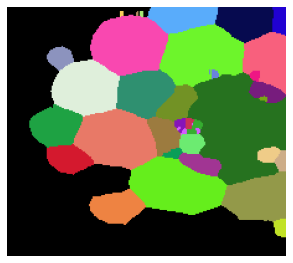

In [24]:
N=250

fig = plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(seg_final_RGB[:,:,N],cmap="gray")
#plt.savefig('seg_final_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)


# Wrong segmentations

In [32]:
import numpy as np
import matplotlib.pyplot as plt

with open("seg_foreground_supervoxel_LRP_graph.npy", "rb") as f:
    seg_final = np.load(f)

# with open("seg_foreground_supervoxel_LRP_graph.npy", "rb") as f:
#     seg_foreground_supervoxel = np.load(f)

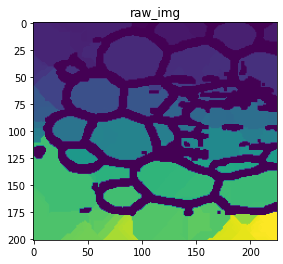

In [23]:
N=250
#print("There are "+str(len(np.unique(seg_foreground_single_cell_with_boundary)))+" cells")
plt.figure()
plt.title("raw_img")
plt.imshow(seg_final[:,:,N])

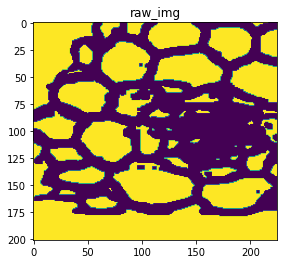

In [37]:
seg_final[seg_final>0] = 20

N=0
#print("There are "+str(len(np.unique(seg_foreground_single_cell_with_boundary)))+" cells")
plt.figure()
plt.title("raw_img")
plt.imshow(seg_final[:,:,N])

In [31]:

seg_final[200,180,0]

13602

In [34]:
np.unique(seg_final[seg_final==0])

array([0], dtype=int32)

In [36]:
seg_final.min()

0